In [6]:
# IMPORTE
import numpy
import pandas as pd
import re
import os
from pprint import pprint
import spacy
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

stoplist = pd.read_csv('stopwords-de.txt', header=None)[0].values.tolist()


In [12]:
# LOAD DATA

name = 'dnbl_visionen23'
filename = name+'.txt'
dfimport = pd.read_csv(filename, sep="|")

commentframe = dfimport['text']
data = commentframe.values.tolist()
print(len(data))
print(data[1])

127
Bisschen mehr Bepflanzung, kostenloses W-LAN


In [16]:

# Load spaCy model

nlp = spacy.load('de_core_news_sm', disable=['parser', 'ner'])
# Assuming 'stoplist' contains your list of stopwords
stoplist = pd.read_csv('stopwords-de.txt', header=None)[0].values.tolist()

# Tokenize and lemmatize the comments, excluding stopwords
data_words_nostops = []

for comment in data:
    # Tokenize the comment using spaCy
    doc = nlp(comment)
    
    # Extract lemmatized words excluding stopwords
    processed_words = [token.lemma_ for token in doc if token.lemma_ not in stoplist]
    
    data_words_nostops.append(processed_words)

In [17]:

# Lemmatisierung
def lemmatization(texts, allowed_postags=['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']):
  texts_out = []
  for sent in texts:
    doc = nlp(" ".join(sent))
    texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
  return texts_out


data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV'])
#print('lemmata: ' + str(data_lemmatized[:9]))

# Lemmatisierte Daten erneut durch Stoplist schleifen
#data_final = [[word for word in doc if len(word) > 2 and word not in stoplist] for doc in data_lemmatized]



In [18]:
# Lemmatisierte Daten erneut durch Stoplist schleifen
data_final = [[word for word in doc if len(word) > 2 and word not in stoplist] for doc in data_lemmatized]
print(data_final[1])

['bissch', 'Bepflanzung', 'kostenloses', 'W-LAN']


In [28]:
type(data_final)

list

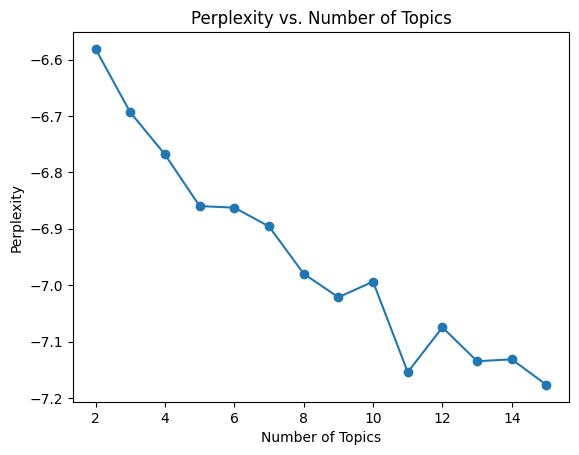

In [19]:
# elbow method to approximate sufficiant number of topics

import matplotlib.pyplot as plt
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# Assuming 'corpus' is your document-term matrix and 'id2word' is the mapping from word ids to words
# You may need to replace 'num_topics_range' with the range of values you want to explore

num_topics_range = range(2, 16)
perplexity_values = []
id2word = corpora.Dictionary(data_final)
corpus = [id2word.doc2bow(text) for text in data_final]

for num_topics in num_topics_range:
    lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42) # CAUTION!
    perplexity = lda_model.log_perplexity(corpus)
    perplexity_values.append(perplexity)

# Plotting the results
plt.plot(num_topics_range, perplexity_values, marker='o')
plt.title('Perplexity vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.savefig('TopicNumElbow.svg')
plt.show()


In [21]:
# TRAINING

num_topics = 9 # Anzahl der Themen, nach denen die Daten gegliedert werden sollen, Zahl kann frei geändert werden
chunks = len(data)

#id2word = corpora.Dictionary(data_final)
#print('id2word: '+str(id2word))

#corpus = [id2word.doc2bow(text) for text in data_final]
#print('corpus: '+str(corpus))

lda_model = gensim.models.ldamodel.LdaModel(
   corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=100,
   update_every=1, chunksize=chunks, passes=10, alpha='auto', per_word_topics=True
)

#pprint(lda_model.print_topics(num_topics=50))
pprint(lda_model.print_topics(num_topics))

doc_lda = lda_model[corpus]


print('\nPerplexity: ', lda_model.log_perplexity(corpus))

[(0,
  '0.070*"Bibliothek" + 0.032*"Zukunft" + 0.026*"sehen" + 0.013*"wünschen" + '
  '0.013*"Mensch" + 0.013*"egal" + 0.013*"digitalisieren" + 0.013*"Bestand" + '
  '0.013*"Idee" + 0.013*"weiterentwickeln"'),
 (1,
  '0.045*"Buch" + 0.013*"Welt" + 0.013*"Galaxie" + 0.013*"Mensch" + '
  '0.007*"Sprache" + 0.007*"vorhanden" + 0.007*"führen" + 0.007*"Vorbild" + '
  '0.007*"Trenity" + 0.007*"Dublin"'),
 (2,
  '0.028*"Zukunft" + 0.019*"klein" + 0.019*"Bibliothek" + 0.019*"Ort" + '
  '0.010*"Teil" + 0.010*"interaktiv" + 0.010*"voneinander" + '
  '0.010*"Begegnungsstätte" + 0.010*"Demokratie" + 0.010*"Jung"'),
 (3,
  '0.022*"generell" + 0.022*"zugänglich" + 0.012*"Bibliothek" + '
  '0.011*"Zukunft" + 0.011*"kreativ" + 0.011*"Wissensnetz" + '
  '0.011*"Gedächtnis" + 0.011*"sammeln" + 0.011*"umgehen" + 0.011*"Kultur"'),
 (4,
  '0.046*"DNB" + 0.019*"Nutzer" + 0.010*"bleiben" + 0.010*"haptisch" + '
  '0.010*"Tauschmöglichkeit" + 0.010*"Literatur" + 0.010*"verknüpfen" + '
  '0.010*"anonym" + 0.010

In [50]:
# Define a mapping from topic numbers to labels
topic_labels = {
    0: "Bestand Digitalisierung",
    1: "Vorbild",
    2: "Begegnungsstätte",
    3: "Gedächtnis Wissensnetz",
    4: "Erlebnis zum Anfassen",
    5: "Frieden",
    6: "Buch Digitalisierung",
    7: "kinderfreundlich",
    8: "Geschichte Museum Buch"
}

In [25]:
import pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, name + 'LDATopics' + '_' + '.html') #_prechunked'+ str(prechunks)

In [26]:
from gensim.models import ldaseqmodel

def assign_topic(lda_model, corpus):
    topics = lda_model.get_document_topics(corpus)
    dominant_topics = [max(t, key=lambda x: x[1])[0] for t in topics]
    return dominant_topics

document_topics = assign_topic(lda_model, corpus)

In [47]:
# writing topic assignment into csv together with all docs

import csv

# Assuming you have document_texts, document_topics, and clusters from the previous steps

# Create a list to store the data
data_n = []

# Iterate through documents and their corresponding topics and clusters
for doc_num, (doc_text, topic) in enumerate(zip(commentframe, document_topics)):
    data_n.append([doc_num, topic, doc_text])

# Write data to CSV file
csv_file_path = name+"_topics_clusters.csv"
with open(csv_file_path, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # Write headers
    writer.writerow(["docnum", "topicnum", "text"])
    # Write data
    writer.writerows(data_n)


In [51]:
# adding topic labels and writing to csv

import pandas as pd

# Read CSV into DataFrame
df = pd.read_csv(name+"_topics_clusters.csv")

# Add a new column 'TopicLabel' to the DataFrame
df['TopicLabel'] = df['topicnum'].map(topic_labels)

# Write the updated DataFrame to a new CSV file
df.to_csv(name+"_topics_clusters_with_labels.csv", index=False)


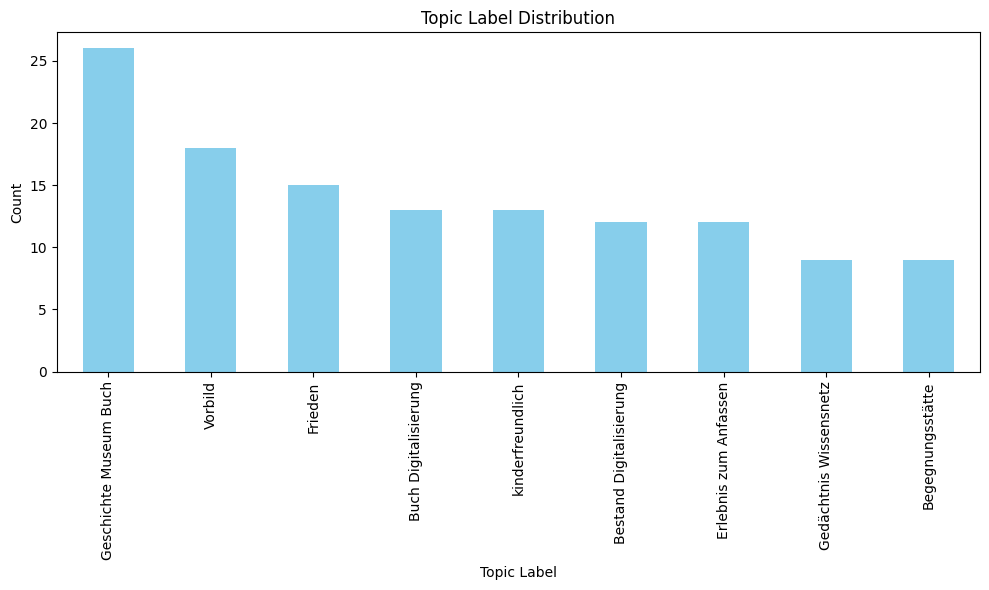

In [75]:
# generating barcharts showing document distribution per topic
dfbar = pd.read_csv(name+"_topics_clusters_with_labels.csv")

topic_label_counts = dfbar['TopicLabel'].value_counts()

plt.figure(figsize=(10, 6))
topic_label_counts.plot(kind='bar', color='skyblue')
plt.title('Topic Label Distribution')
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(name+"_DocsPerTopic_barchart.svg")
plt.show()


In [64]:
# determine word frequencies

import pandas as pd
from collections import Counter
import re


def get_word_frequencies_from_list_of_lists(list_of_lists):
    # Concatenate all words from the list of lists into a single list
    all_words = [word for sublist in list_of_lists for word in sublist if word != '--']

    # Calculate word frequencies using Counter
    word_frequencies = Counter(all_words)

    return word_frequencies

# Example usage
frequencies = get_word_frequencies_from_list_of_lists(data_final)

# Print word frequencies
for word, frequency in frequencies.items():
    print(f"{word}: {frequency}")


Bibliothek: 29
Zukunft: 17
Mensch: 9
passend: 1
Medium: 2
befinden: 1
Glasgebäude: 1
Lesesal: 1
Open-Access: 1
Bewegung: 1
durchsetzen: 1
sodass: 1
Bestand: 4
stark: 1
vergrößern: 1
Besucher: 1
regelmäßig: 1
bissch: 2
Bepflanzung: 1
kostenloses: 1
W-LAN: 1
geben: 5
Tablett: 2
Buch: 30
lesen: 11
automatisch: 1
Bücher-Laufband: 1
bleiben: 3
Jahr: 5
bitte: 1
sammeln: 1
aktiv: 2
kreativ: 2
Beziehung: 1
Publikation: 1
herstellen: 1
zugänglich: 3
Wissensnetz: 1
publizistisch: 1
Gedächtnis: 2
umgehen: 1
Erkenntnis: 1
gewinnen: 1
sprach: 1
Kultur: 1
Privatsphäre: 1
z.B.: 2
Bücherregal: 1
Digitalisierung: 5
nutz: 1
eher: 2
lernen: 4
sichtbar: 2
Ort: 8
gesellschaftlich: 1
Diskurs: 2
teilnehmen: 1
Kulturinstitutione: 1
Bildungseinrichtung: 1
bilden: 1
Fundament: 1
Demokratie: 2
-digitale: 1
Abrufbarkeit: 1
historisch: 2
Dokument: 2
-Vereinfachung: 1
Vereinfachung: 1
Bearbeitung: 1
verfassungsfreundlich: 1
Text: 2
Frieden: 3
indiziern: 1
Verfügung: 1
stehen: 2
schallgeschützt: 1
Leseecke: 3
wünsch

In [66]:
# writing word frequencies to txt

frequencies_file_path = name+'_word_frequencies.txt'

# Example usage
with open(frequencies_file_path, 'w') as file:
    for word, frequency in frequencies.items():
        file.write(f"{word}: {frequency}\n")

print(f"Worthäufigkeiten in folgende Datei geschrieben: {frequencies_file_path}")


Worthäufigkeiten in folgende Datei geschrieben: dnbl_visionen23_word_frequencies.txt


/home/freybek/envs/jupyterenv/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


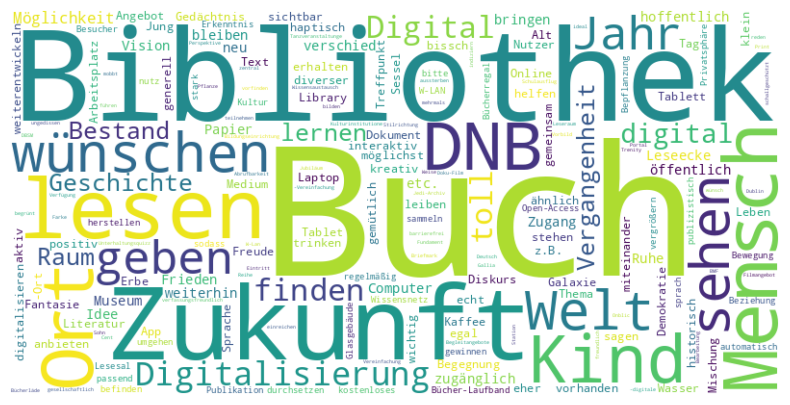

In [67]:
# wordcloud generator

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencies)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.savefig(name+'_WordcloudFrequencies.svg')
plt.show()
